# Прикладной анализ временных рядов

Выполнил: студент AI Talent Hub ITMO \
ФИО: Щетинников К. \
Группа: M4254

## Формулировка задания

Построить модель прогнозирования спроса (продаж) на товары в магазине `STORE_2` офлаин-ритейлера в США. Всего в магазине 15 артикулов (товаров). Прогнозировать продажи нужно на неделю, на месяц и на квартал. В качестве дополнительной информации вам переданы данные о цене товара (меняются раз в неделю, а также о праздниках в США).

### Задание 1. 
Реализовать класс, который умеет: 

1) предобрабатывать исходные данные в удобный формат; 

2) обучаться для задачи прогнозирования; 

3) оценивать качество своих прогнозов;

4) сохранять модели и подгружать их; 

5) Прогнозировать продажи на неделю, на месяц и на квартал.

Должна быть рабочая программа, которая делает инференс (прогнозирование на произвольном тестовом датасете (аналогично тому, который есть у вас)).


### Задание 2. 
Подготовить отчёт о решении данной задачи в виде jupyter ноутбука. В отчёте, в частности, вы должны ответить на следующие вопросы:

1) Какие методы предобработки данных вы использовали?

2) Какие модели пробовали? Почему пробовали именно их?

3) Как вы проверяете качество модели? На каких данных? Какие метрики используюте? Чем обусловлен выбор именно этих метрик?

4) Какое итоговое качество модели на тестовом датасете?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


sns.set_theme()

In [2]:
def plot_acf_pacf(series, item_id, acf_lags=100, pacf_lags=30):
    fig, axes = plt.subplots(3, 1, figsize=(10, 8))

    axes[0].plot(series.date, series.cnt)
    axes[0].set_title(f'Time series {item_id}')

    plot_acf(series.cnt, lags=acf_lags, ax=axes[1])
    axes[1].set_title('Autocorrelation Function (ACF)')

    plot_pacf(series.cnt, lags=pacf_lags, ax=axes[2])
    axes[2].set_title('Partial Autocorrelation Function (PACF)')

    plt.tight_layout()
    plt.show()

## Данные

1. Посмотрим на данные

File: shop_sales_dates


• date: The date in a “y-m-d” format.

• wm_yr_wk: The id of the week the date belongs to.

• weekday: The type of the day (Saturday, Sunday, …, Friday).

• wday: The id of the weekday, starting from Saturday.

• month: The month of the date.

• year: The year of the date.

• event_name_1: If the date includes an event, the name of this event.

• event_type_1: If the date includes an event, the type of this event.

• event_name_2: If the date includes a second event, the name of this event.

• event_type_2: If the date includes a second event, the type of this event.

• date_id: id of the date

In [3]:
# данные о датах и праздниках
calendar = pd.read_csv('./data/shop_sales_dates.csv')
calendar['date'] = pd.to_datetime(calendar['date'])
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,date_id,CASHBACK_STORE_1,CASHBACK_STORE_2,CASHBACK_STORE_3
0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,1,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,NaN,NaN,NaN,NaN,2,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,NaN,NaN,NaN,NaN,3,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,NaN,NaN,NaN,NaN,4,0,1,1
4,2011-02-02,11101,Wednesday,5,2,2011,NaN,NaN,NaN,NaN,5,1,1,0


In [4]:
# посмотрим на данные о праздниках
print('event_name_1\n', calendar.event_name_1.unique(), '\n')
print('event_type_1\n', calendar.event_type_1.unique(), '\n')
print('event_name_2\n', calendar.event_name_2.unique(), '\n')
print('event_type_2\n', calendar.event_type_2.unique(), '\n')

event_name_1
 [nan 'SuperBowl' 'ValentinesDay' 'PresidentsDay' 'LentStart' 'LentWeek2'
 'StPatricksDay' 'Purim End' 'OrthodoxEaster' 'Pesach End' 'Cinco De Mayo'
 "Mother's day" 'MemorialDay' 'NBAFinalsStart' 'NBAFinalsEnd'
 "Father's day" 'IndependenceDay' 'Ramadan starts' 'Eid al-Fitr'
 'LaborDay' 'ColumbusDay' 'Halloween' 'EidAlAdha' 'VeteransDay'
 'Thanksgiving' 'Christmas' 'Chanukah End' 'NewYear' 'OrthodoxChristmas'
 'MartinLutherKingDay' 'Easter'] 

event_type_1
 [nan 'Sporting' 'Cultural' 'National' 'Religious'] 

event_name_2
 [nan 'Easter' 'Cinco De Mayo' 'OrthodoxEaster' "Father's day"] 

event_type_2
 [nan 'Cultural' 'Religious'] 



In [5]:
# закодируем праздники и учтем выходные дни
calendar = pd.get_dummies(calendar, columns=['event_type_1'], prefix='type', dtype=int)
calendar['is_weekend'] = calendar['wday'].apply(lambda x: 1 if x < 3 else 0)
calendar.drop(columns=['event_name_1', 'event_name_2', 'event_type_2', 'CASHBACK_STORE_1', 'CASHBACK_STORE_3'], inplace=True)
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,date_id,CASHBACK_STORE_2,type_Cultural,type_National,type_Religious,type_Sporting,is_weekend
0,2011-01-29,11101,Saturday,1,1,2011,1,0,0,0,0,0,1
1,2011-01-30,11101,Sunday,2,1,2011,2,0,0,0,0,0,1
2,2011-01-31,11101,Monday,3,1,2011,3,0,0,0,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,4,1,0,0,0,0,0
4,2011-02-02,11101,Wednesday,5,2,2011,5,1,0,0,0,0,0


File: shop_sales_prices


• store_id: The id of the store where the product is sold.

• item_id: The id of the product.

• wm_yr_wk: The id of the week.

• sell_price: The price of the product for the given week/store. The price is provided per week (average across seven days). If not available, this means that the product was not sold during the examined week. Note that although prices are constant at weekly basis, they may change through time (both training and test set).

In [6]:
# данные о средней стоимости единиц товаров в неделю
prices = pd.read_csv('./data/shop_sales_prices.csv')
prices = prices[prices['store_id'] == 'STORE_2']
prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,STORE_2,STORE_2_085,11101,1.00
1,STORE_2,STORE_2_043,11101,2.88
2,STORE_2,STORE_2_054,11101,2.28
3,STORE_2,STORE_2_090,11101,1.25
4,STORE_2,STORE_2_252,11101,1.48


In [7]:
prices.item_id.value_counts().to_frame()

# видно, что у некоторых товаров меньше записей в таблице

,count
item_id,
STORE_2_085,260
STORE_2_043,260
STORE_2_054,260
STORE_2_090,260
STORE_2_252,260
STORE_2_376,260
STORE_2_524,260
STORE_2_555,260
STORE_2_586,260


File: shop_sales


• item_id: The id of the product.

• store_id: The id of the store where the product is sold.

• date_id: id of the date

• cnt: The number of units sold at day i

In [8]:
# данные о количестве продаж артикулов
sales = pd.read_csv('./data/shop_sales.csv')
sales = sales[sales['store_id'] == 'STORE_2']
sales.head()

,item_id,store_id,date_id,cnt
0,STORE_2_085,STORE_2,1,3
1,STORE_2_085,STORE_2,2,8
2,STORE_2_085,STORE_2,3,0
3,STORE_2_085,STORE_2,4,3
4,STORE_2_085,STORE_2,5,0


2. Соединим данные в одну таблицу продаж

In [9]:
df = calendar.merge(sales, on='date_id') \
             .merge(prices, 
                    on=['item_id', 'store_id', 'wm_yr_wk'], 
                    how='left').sort_values(by='date')
df

,date,wm_yr_wk,weekday,wday,month,year,date_id,CASHBACK_STORE_2,type_Cultural,type_National,type_Religious,type_Sporting,is_weekend,item_id,store_id,cnt,sell_price
0,2011-01-29,11101,Saturday,1,1,2011,1,0,0,0,0,0,1,STORE_2_085,STORE_2,3,1.00
14,2011-01-29,11101,Saturday,1,1,2011,1,0,0,0,0,0,1,STORE_2_716,STORE_2,0,NaN
13,2011-01-29,11101,Saturday,1,1,2011,1,0,0,0,0,0,1,STORE_2_714,STORE_2,18,1.48
12,2011-01-29,11101,Saturday,1,1,2011,1,0,0,0,0,0,1,STORE_2_681,STORE_2,14,1.25
11,2011-01-29,11101,Saturday,1,1,2011,1,0,0,0,0,0,1,STORE_2_587,STORE_2,0,2.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27271,2016-01-21,11551,Thursday,6,1,2016,1819,0,0,0,0,0,0,STORE_2_043,STORE_2,0,2.00
27270,2016-01-21,11551,Thursday,6,1,2016,1819,0,0,0,0,0,0,STORE_2_085,STORE_2,4,0.98
27283,2016-01-21,11551,Thursday,6,1,2016,1819,0,0,0,0,0,0,STORE_2_714,STORE_2,11,1.58
27276,2016-01-21,11551,Thursday,6,1,2016,1819,0,0,0,0,0,0,STORE_2_376,STORE_2,0,1.00


## EDA

In [10]:
# количество записей по годам
df.year.value_counts().to_frame().sort_index()

# видно, что количество записей о продажах неодинаковое в каждый год

,count
year,
2011,5055
2012,5490
2013,5475
2014,5475
2015,5475
2016,315


In [11]:
# количество товаров в магазине
len(df.item_id.unique())

15

In [12]:
# количество записей о продаже артикула
df.item_id.value_counts().to_frame().sort_values(by='count')

,count
item_id,
STORE_2_085,1819
STORE_2_716,1819
STORE_2_714,1819
STORE_2_681,1819
STORE_2_587,1819
STORE_2_555,1819
STORE_2_524,1819
STORE_2_586,1819
STORE_2_376,1819


In [13]:
# пропуски в данных
print('Data count', df.shape[0])
print()
print('cnt', sum(df.cnt.isna()))
print('sell_price', sum(df.sell_price.isna()))
print('CASHBACK_STORE_2', sum(df.CASHBACK_STORE_2.isna()))

Data count 27285

cnt 0
sell_price 1421
CASHBACK_STORE_2 0


In [14]:
print(df.CASHBACK_STORE_2.value_counts())

CASHBACK_STORE_2
0    18285
1     9000
Name: count, dtype: int64


### 1. Визуализация временных рядов

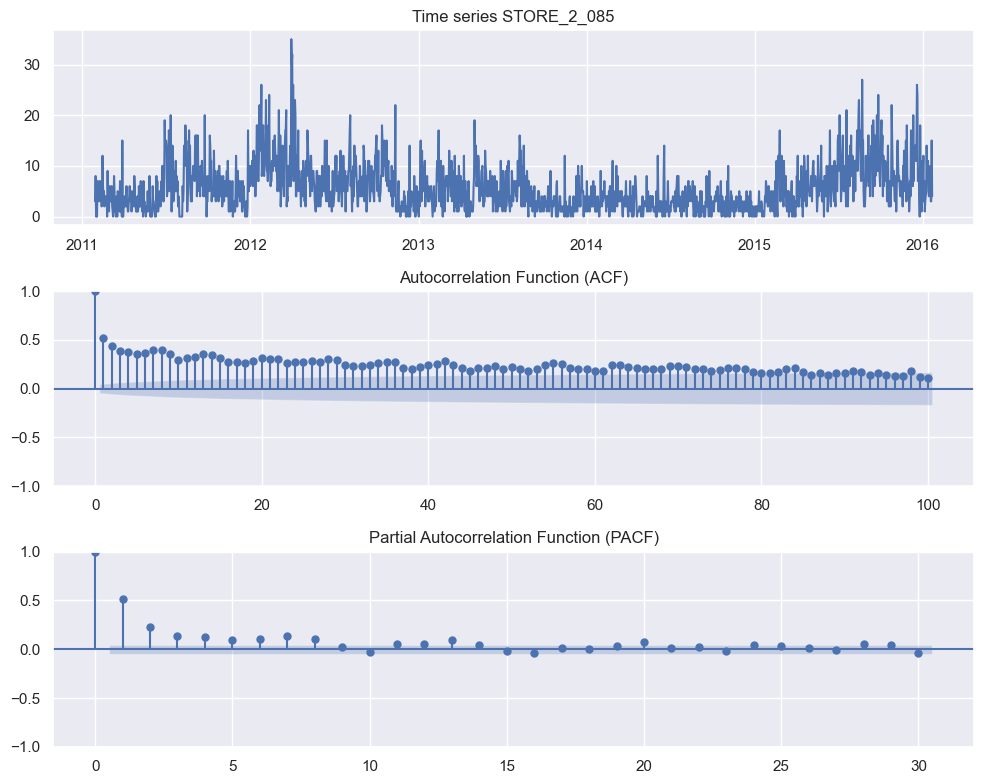

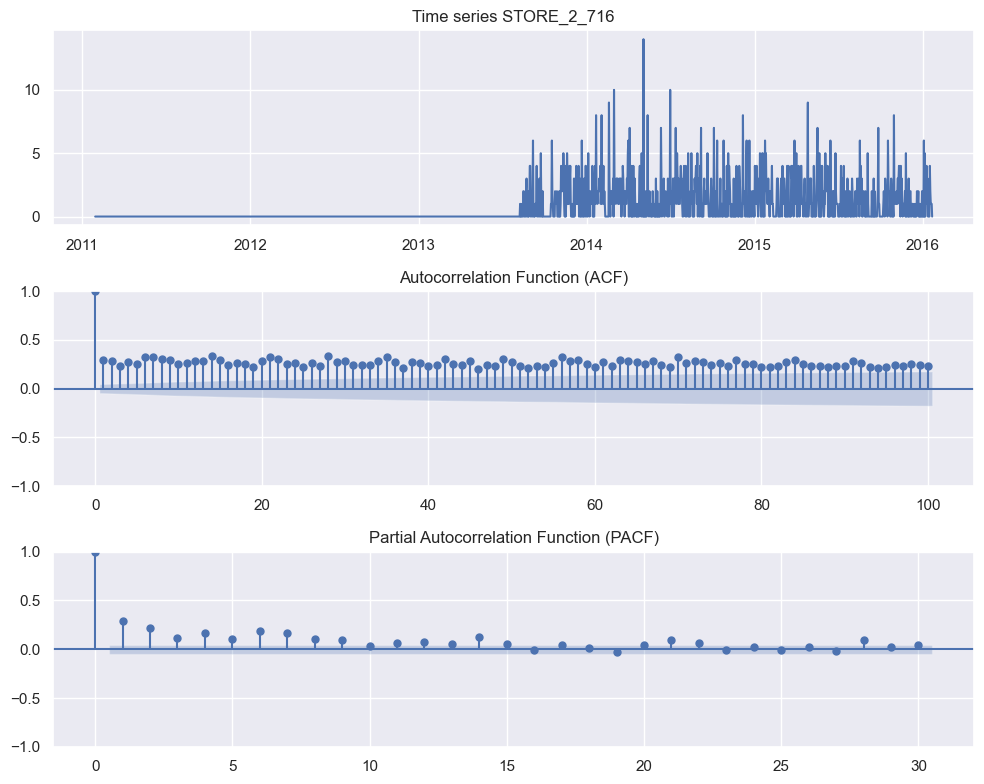

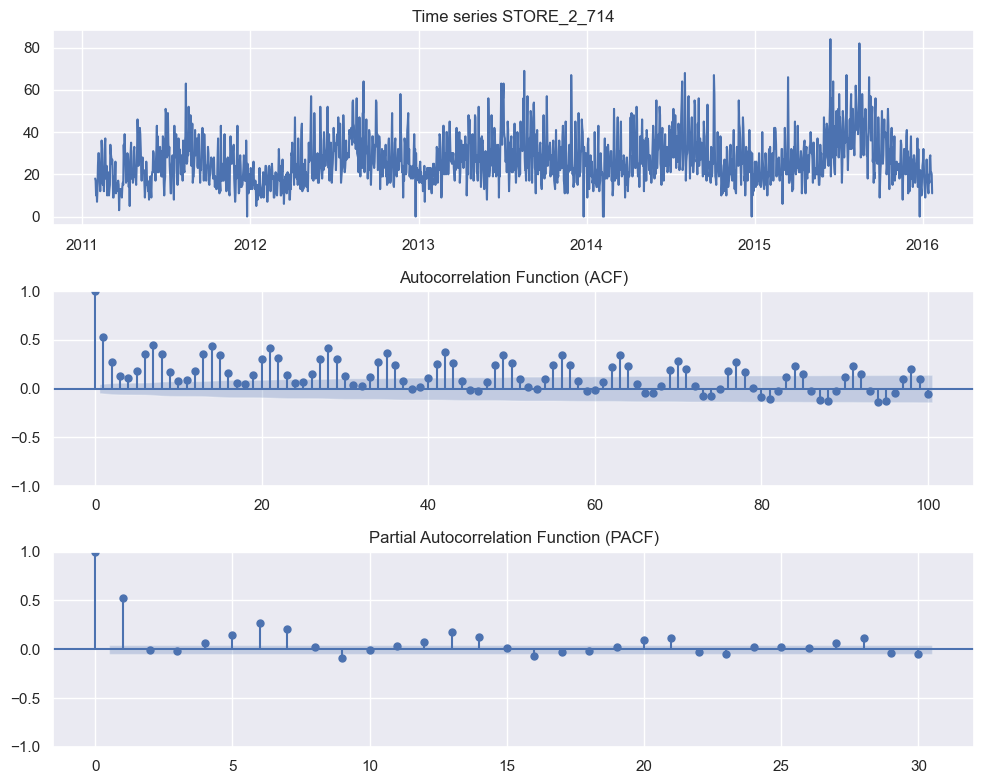

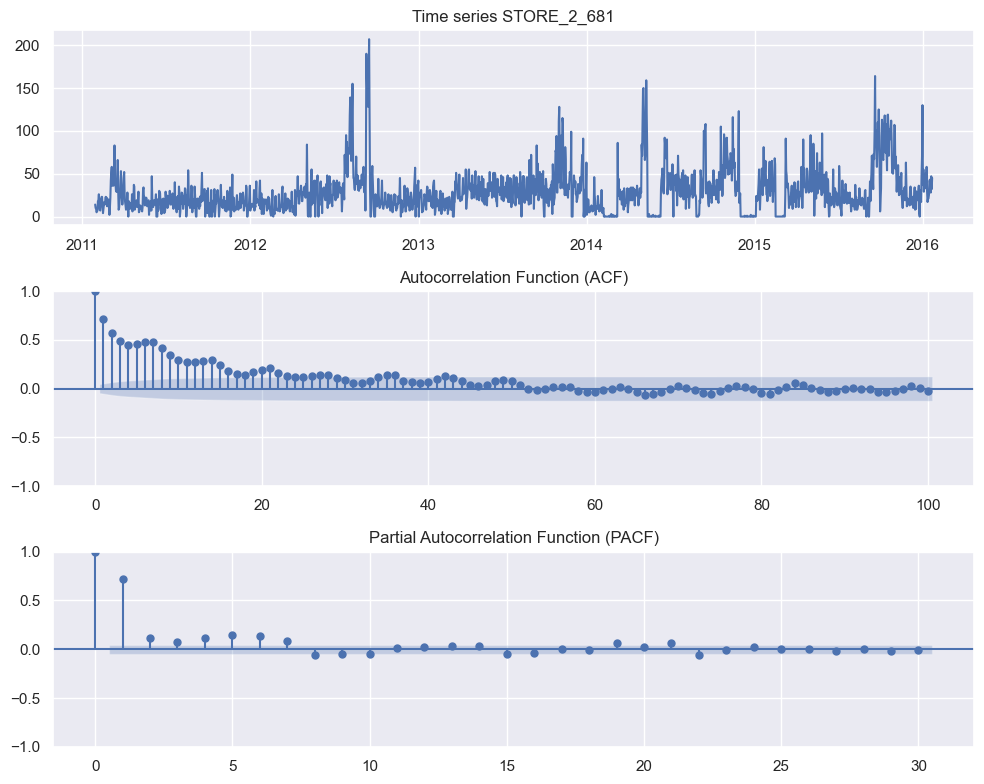

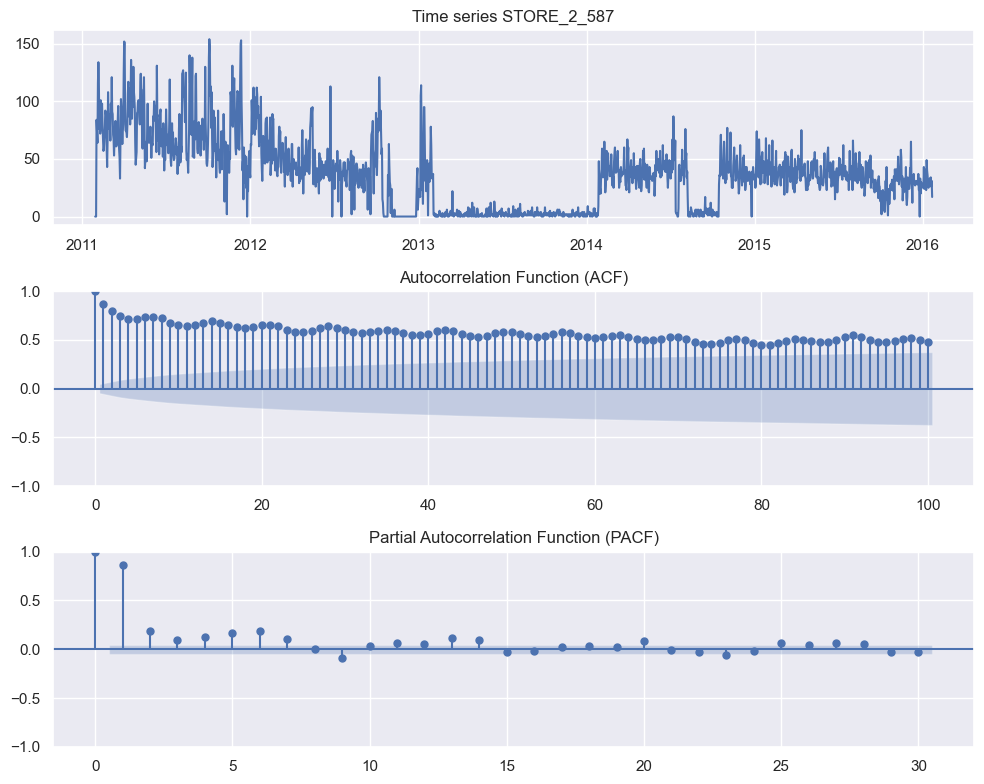

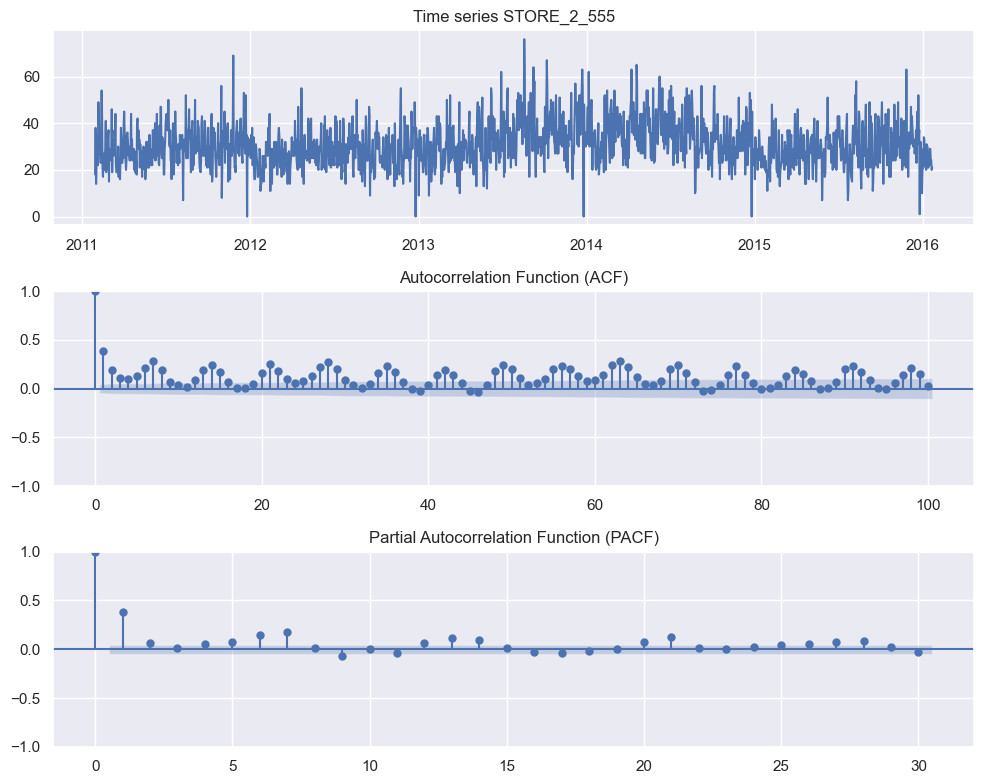

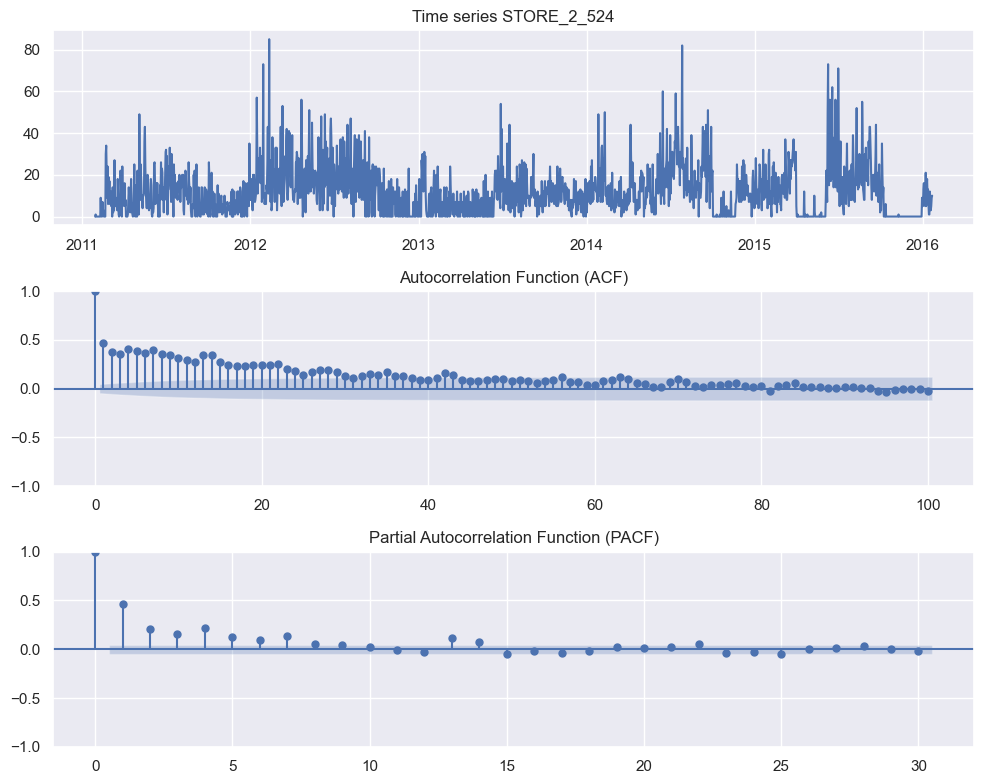

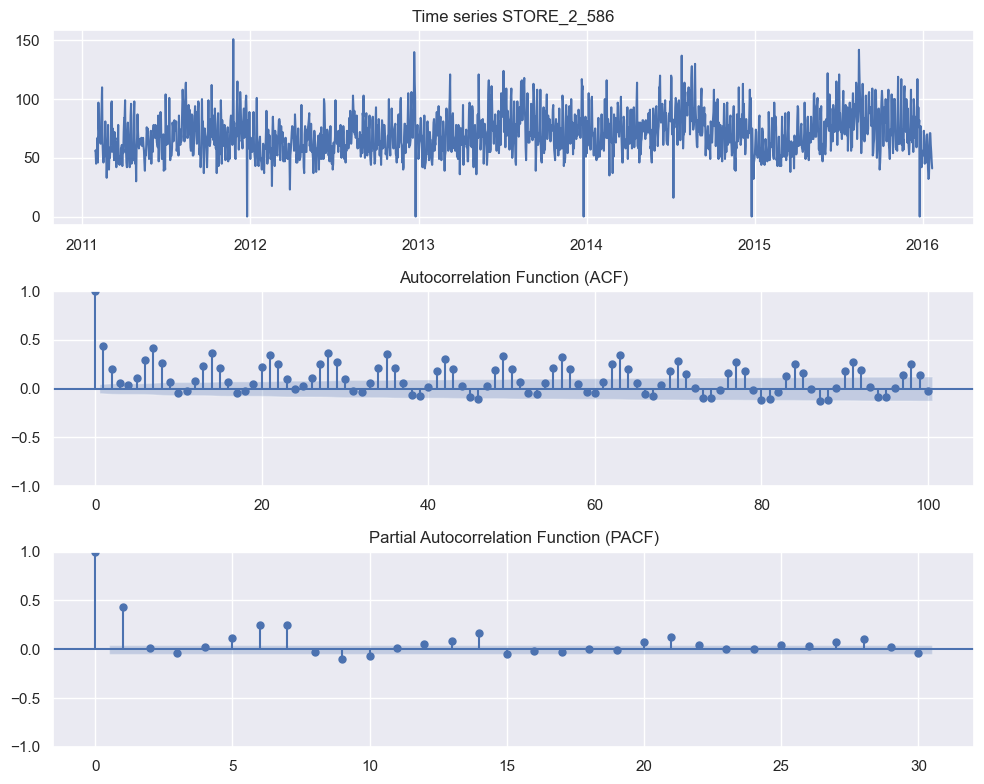

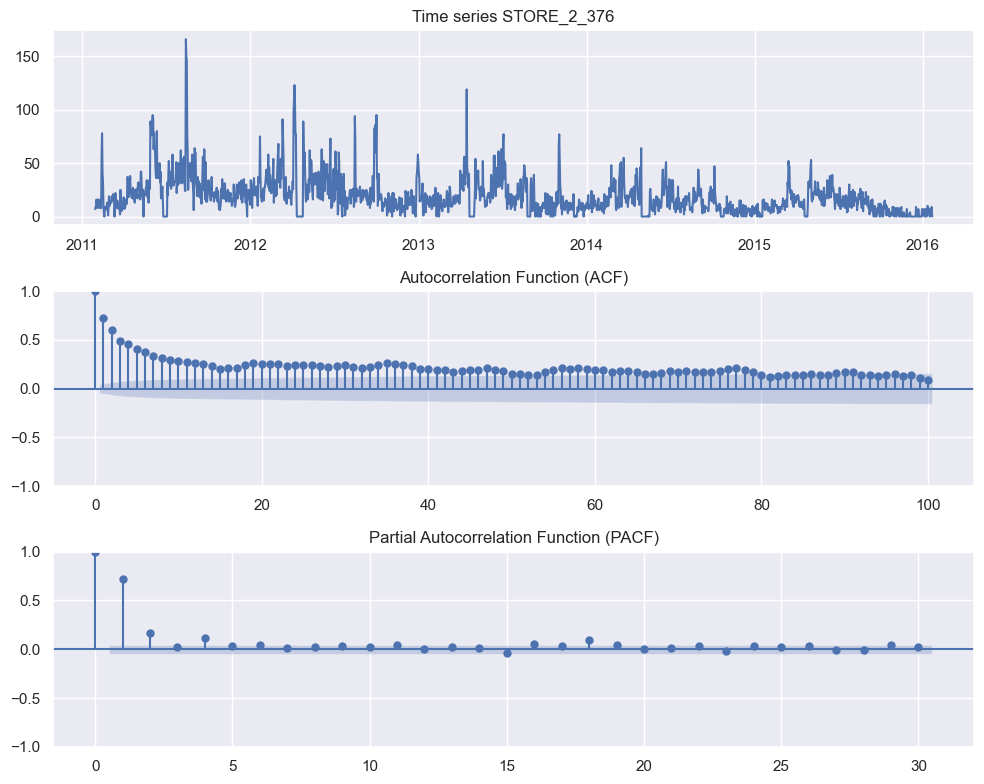

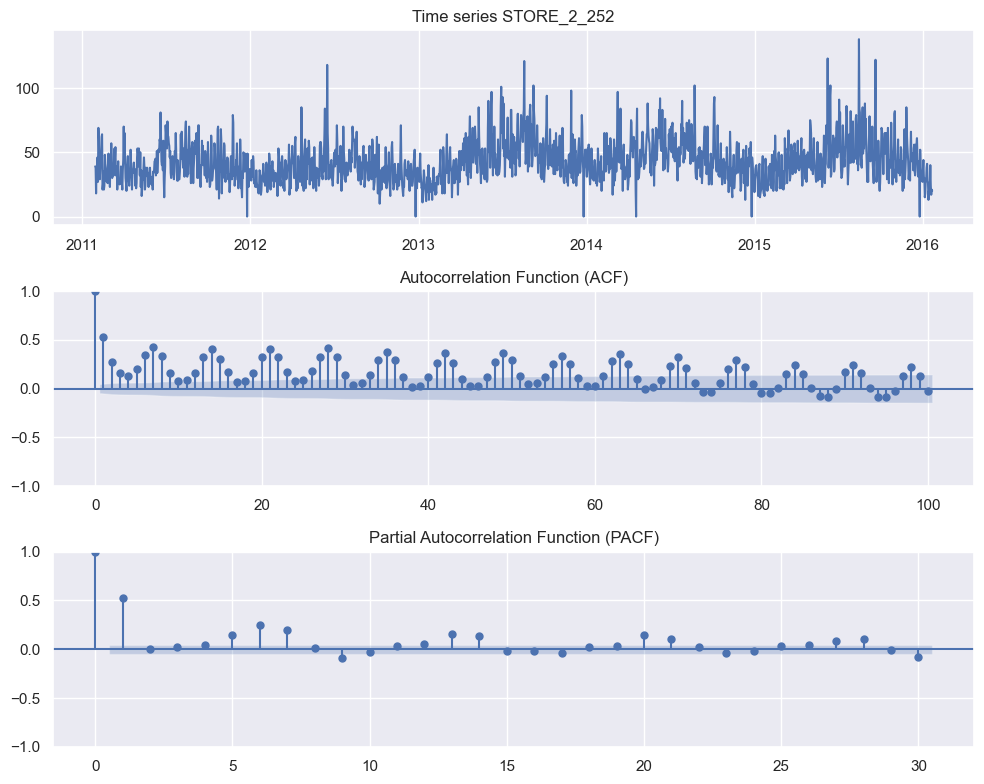

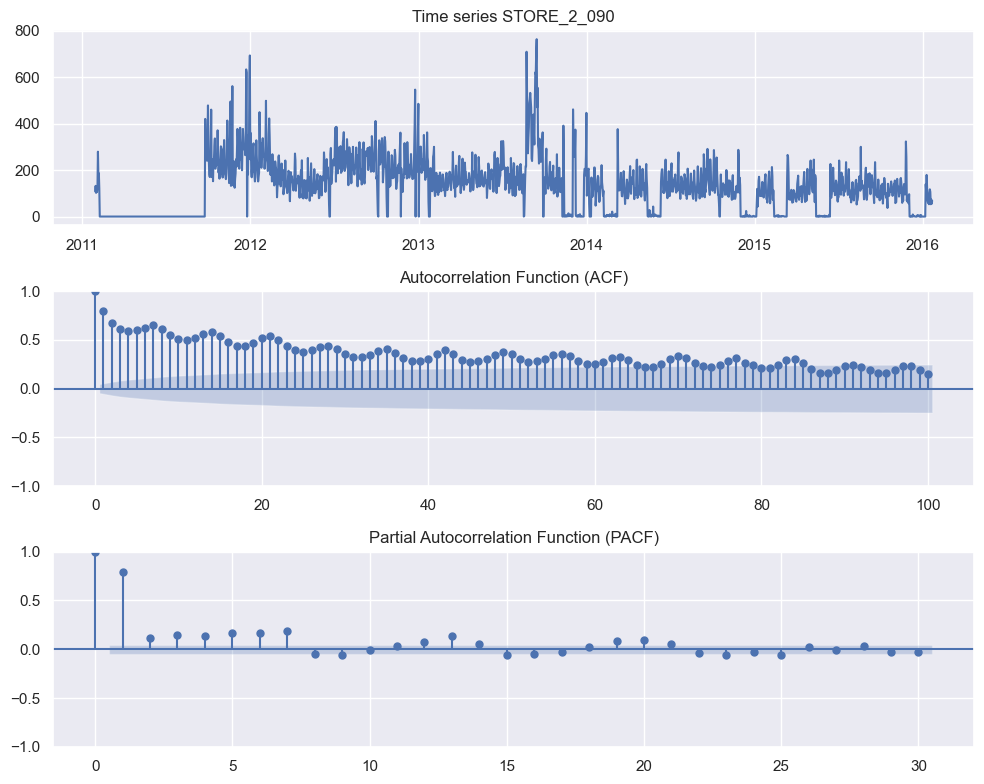

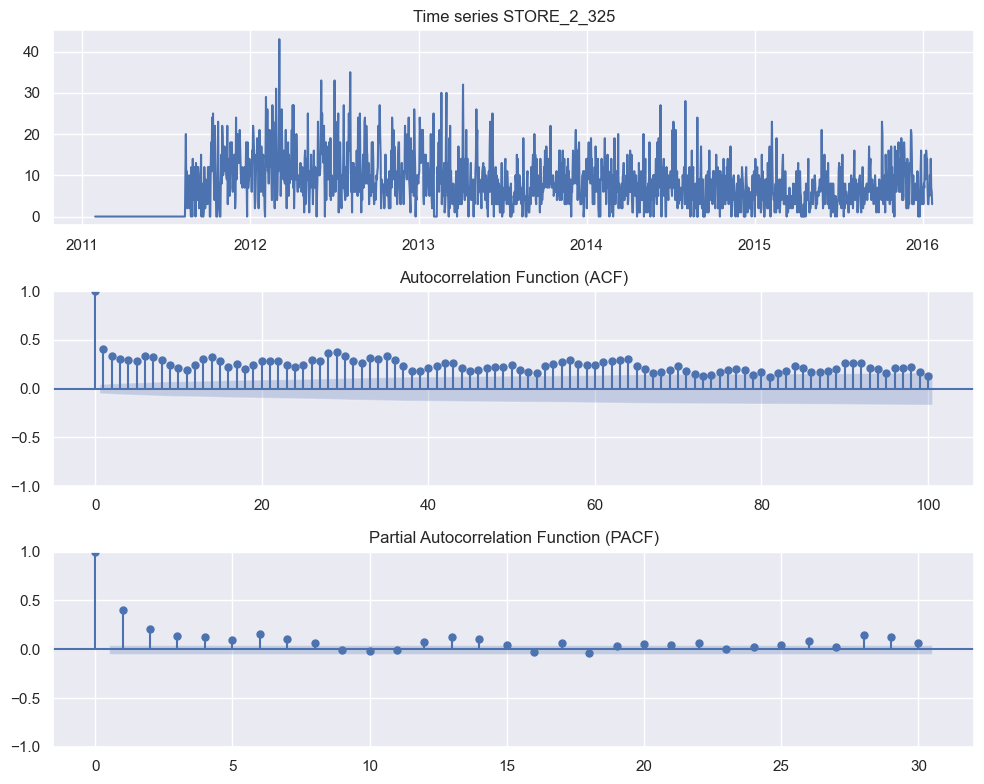

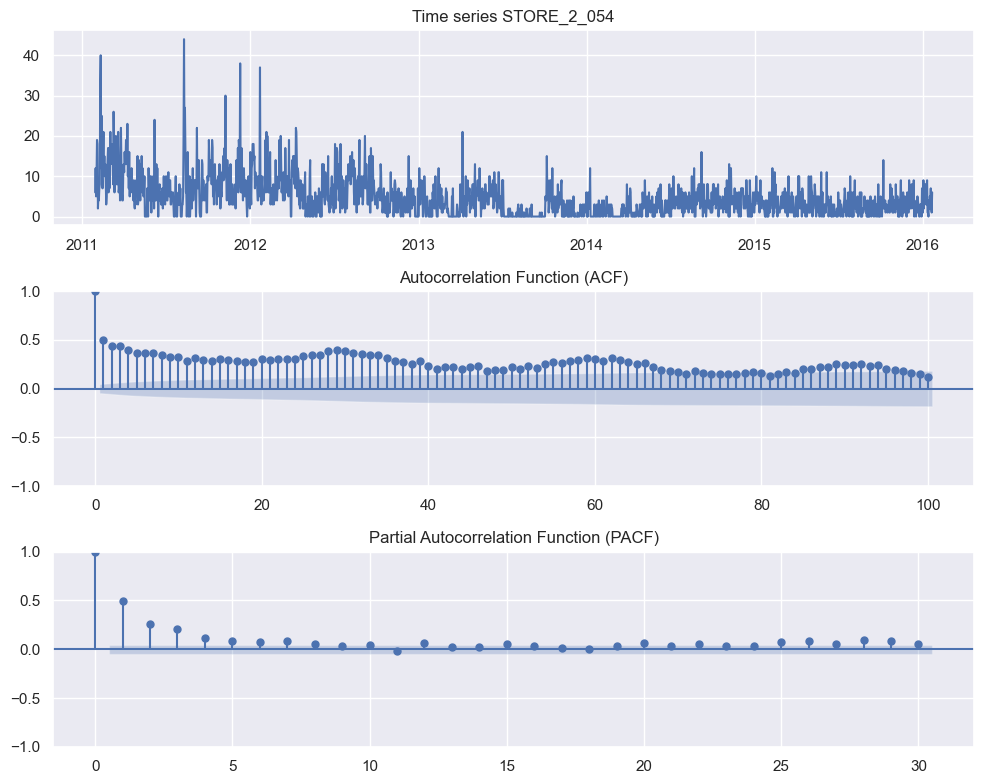

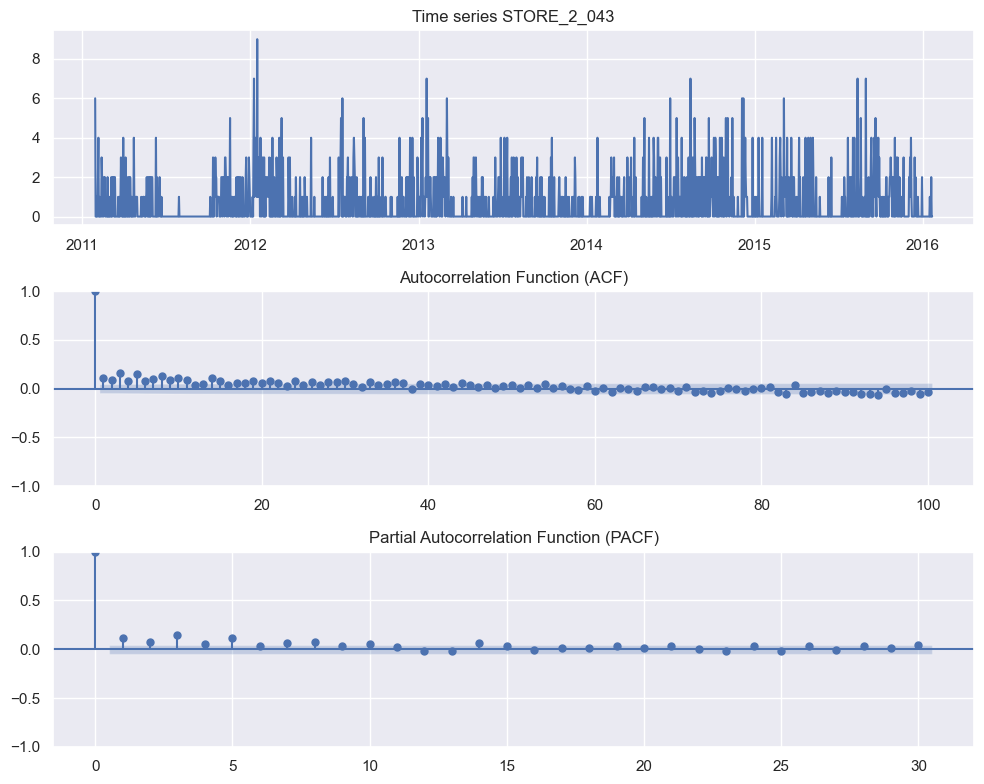

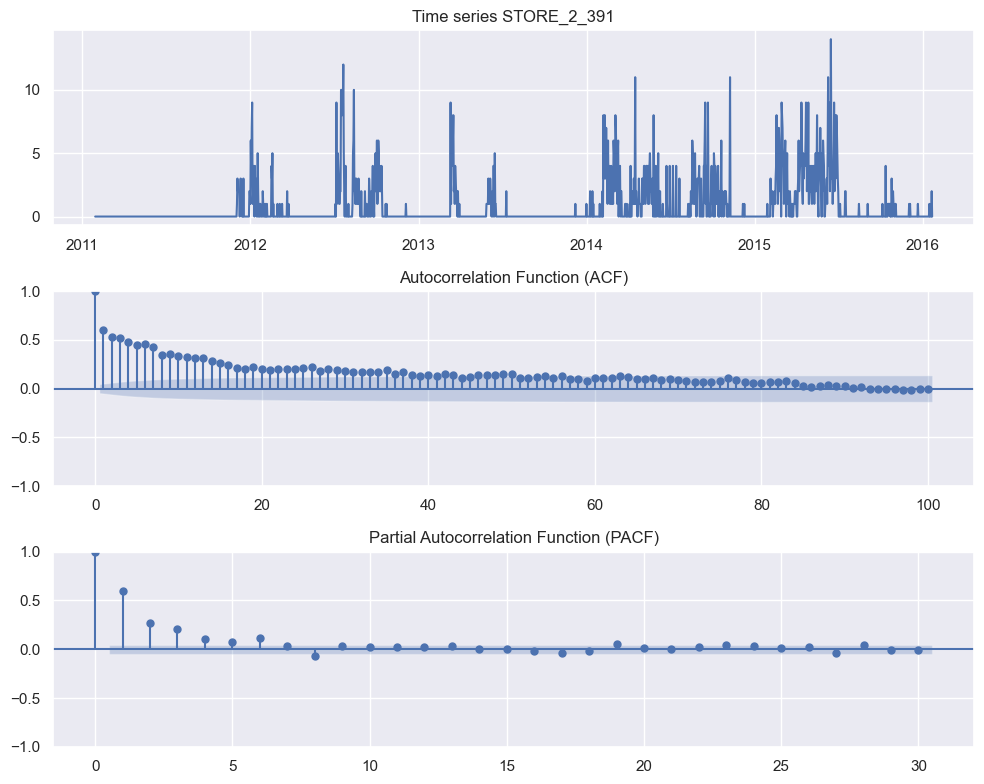

In [15]:
arts = df.item_id.unique()

for art in arts:
    df_art = df[(df.item_id == art) & (df.store_id=='STORE_2')]
    plot_acf_pacf(df_art, art, acf_lags=100, pacf_lags=30)

По графикам автокорреляционных функций продаж товаров видно, что мы имеем разнородные данные.
Есть ряды:
1. Только с трендом
2. Только с сезонностью
3. С трендом и сезонностью
4. Белый шум

In [16]:
df.to_csv('./data/full_data.csv', index=False)

1. Автокорреляционная функция
2. Аддитивное разложине, мультипликативное разложение
3. Критерии проверки стационарности ряда

Тренды
1. Дифференцирование, сезонное дифференцирование, отношение
2. Скользящее среднее

Сезонность:
1. Бинарные переменные
2. Периодические функции


Декомпозиция:
1. Классическая
2. X12
3. STL-декомпозиция


Дополнительно:
1. Стабилизация дисперсии Преобразование Бокса-Кокса и обратное
2. Заполнение пропусков
3. Обнаружение аномалий (анализ остатков)